In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# PCAによる次元削減
def perform_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

# t-SNEによる次元削減
def perform_tsne(data, n_components=2, perplexity=30, max_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, max_iter=max_iter)
    return tsne.fit_transform(data)

# UMAPによる次元削減
def perform_umap(data, n_components=2, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    return reducer.fit_transform(data)

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift
import hdbscan
import numpy as np

# DBSCANによるクラスタリング
def perform_dbscan(data, eps=0.5, min_samples=5):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    return model.fit_predict(data)

# HDBSCANによるクラスタリング
def perform_hdbscan(data, min_cluster_size=5):
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    return model.fit_predict(data)

# OPTICSによるクラスタリング
def perform_optics(data, min_samples=5, max_eps=np.inf):
    model = OPTICS(min_samples=min_samples, max_eps=max_eps)
    return model.fit_predict(data)

# GMMによるクラスタリング
def perform_gmm(data, n_components=3):
    model = GaussianMixture(n_components=n_components, random_state=42)
    return model.fit_predict(data)

# Mean-Shiftによるクラスタリング
def perform_mean_shift(data, bandwidth=None):
    model = MeanShift(bandwidth=bandwidth)
    return model.fit_predict(data)

# Spectral Clusteringによるクラスタリング
def perform_spectral(data, n_clusters=3):
    model = SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors')
    return model.fit_predict(data)

In [3]:
import matplotlib.pyplot as plt

# 次元削減とクラスタリング結果を可視化
def visualize_clusters(dim_reduction_result, labels, title="Cluster Visualization"):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(dim_reduction_result[:, 0], dim_reduction_result[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(title, fontsize=16)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# 区切り線の表示用関数
def print_separator(title):
    """
    区切り線を表示する関数

    Args:
        title (str): 区切り線に表示するタイトル
    """
    print("\n" + "="*50)
    print(f" {title} ")
    print("="*50 + "\n")

In [4]:
def add_clustering_labels(df, column_name, dim_reduction_function, clustering_function, **kwargs):
    """
    次元削減とクラスタリングを行い、結果をデータフレームに追加する関数

    Args:
        df (DataFrame): 元のデータフレーム
        column_name (str): 対象の特徴量列
        dim_reduction_function (callable): 次元削減関数
        clustering_function (callable): クラスタリング関数
        **kwargs: クラスタリング関数に渡す追加引数

    Returns:
        DataFrame: クラスタリング結果を含むデータフレーム
    """
    # 特徴量を取得
    if isinstance(df[column_name].iloc[0], (list, np.ndarray)):
        data = np.stack(df[column_name].dropna().values)
    else:
        data = df[column_name].dropna().values.reshape(-1, 1)
    
    # 次元削減
    reduced_data = dim_reduction_function(data)
    
    # クラスタリング
    labels = clustering_function(reduced_data, **kwargs)
    
    # 元のデータフレームにラベルを追加
    df_with_labels = df.copy()
    df_with_labels[f"{column_name}_cluster"] = -1  # 初期化（-1: ノイズ）
    df_with_labels.loc[df[column_name].notna(), f"{column_name}_cluster"] = labels
    
    return df_with_labels


In [5]:
def list_images_by_cluster(df, column_name, cluster_column):
    """
    クラスタごとの画像パスをリスト化する関数

    Args:
        df (DataFrame): クラスタリング結果を含むデータフレーム
        column_name (str): 画像パス列名
        cluster_column (str): クラスタラベル列名

    Returns:
        dict: クラスターIDをキー、画像パスのリストを値とする辞書
    """
    clusters = df.groupby(cluster_column)[column_name].apply(list)
    return clusters.to_dict()


In [6]:
def display_images_by_cluster(cluster_dict, num_images=5):
    """
    クラスタごとの画像をランダムに表示する関数

    Args:
        cluster_dict (dict): クラスターごとの画像パスを格納した辞書
        num_images (int): 各クラスターから表示する画像数
    """
    for cluster_id, image_paths in cluster_dict.items():
        print(f"Cluster {cluster_id}: {len(image_paths)} images")
        
        # クラスタ内からランダムに画像を選択
        sampled_images = random.sample(image_paths, min(len(image_paths), num_images))
        
        # サムネイル表示
        fig, axes = plt.subplots(1, len(sampled_images), figsize=(15, 5))
        fig.suptitle(f"Cluster {cluster_id}", fontsize=16)
        
        for ax, img_path in zip(axes, sampled_images):
            try:
                img = Image.open(img_path)
                img.thumbnail((128, 128))  # サムネイルサイズ
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(img_path.split("/")[-1], fontsize=8)
            except Exception as e:
                ax.axis("off")
                ax.set_title("Error", fontsize=8)
        
        plt.tight_layout()
        plt.show()


In [7]:
import pandas as pd

# 元のデータフレームを読み込み
df = pd.read_parquet('../04_Features/images.parquet')

# 新しいデータフレームを作成（必要な列のみコピー）
df_cluster = df[['index', 'dirname', 'path', 'width', 'height', 'created_time', 'modified_time', 'color_mode', 'file_size']].copy()

# 指定された組み合わせ
combinations = [
    {"feature": "color_histogram_std", "dim_reduction": perform_pca, "clustering": perform_dbscan, "suffix": "PCA_DBSCAN"},
    {"feature": "color_histogram_std", "dim_reduction": perform_umap, "clustering": perform_dbscan, "suffix": "UMAP_DBSCAN"},
    {"feature": "glcm_features_std", "dim_reduction": perform_pca, "clustering": perform_gmm, "suffix": "PCA_GMM"},
    {"feature": "hog_features_umap_std", "dim_reduction": perform_umap, "clustering": perform_gmm, "suffix": "UMAP_GMM"},
]

# 各組み合わせに対して処理
for combo in combinations:
    feature = combo["feature"]
    dim_reduction = combo["dim_reduction"]
    clustering = combo["clustering"]
    suffix = combo["suffix"]
    
    print(f"Processing: {feature} with {suffix}")

    # 特徴量データを準備
    if isinstance(df[feature].iloc[0], (list, np.ndarray)):
        data = np.stack(df[feature].dropna().values)
    else:
        data = df[feature].dropna().values.reshape(-1, 1)

    # 次元削減
    reduced_data = dim_reduction(data)

    # クラスタリング
    if clustering == perform_gmm:
        labels = clustering(reduced_data, n_components=3)  # GMM用
    elif clustering == perform_dbscan:
        labels = clustering(reduced_data, eps=0.5, min_samples=5)  # DBSCAN用
    else:
        labels = clustering(reduced_data)  # その他の手法

    # クラスタリング結果を新しい列として追加
    cluster_column_name = f"{feature}_{suffix}_cluster"
    df_cluster[cluster_column_name] = -1  # 初期化（-1: ノイズ）
    df_cluster.loc[df[feature].notna(), cluster_column_name] = labels

# 保存（必要に応じて）
df_cluster.to_parquet('./df_cluster.parquet', index=False)

# 結果確認
print(df_cluster.head())


Processing: color_histogram_std with PCA_DBSCAN
Processing: color_histogram_std with UMAP_DBSCAN


/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing: glcm_features_std with PCA_GMM
Processing: hog_features_umap_std with UMAP_GMM


/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


   index dirname                                               path  width  \
0      0      61  ../mydata/00_working/2022-05-02/61/59-62-65-IM...   3000   
1      1      61  ../mydata/00_working/2022-05-02/61/24-30-36-IM...   3000   
2      2      61  ../mydata/00_working/2022-05-02/61/29-35-40-IM...   3000   
3      3      61  ../mydata/00_working/2022-05-02/61/23-3-11-DSC...   3000   
4      4      61  ../mydata/00_working/2022-05-02/61/40-45-5-DSC...   3000   

   height               created_time              modified_time color_mode  \
0    2000 2024-11-22 20:05:13.475698 2024-11-22 20:05:13.475698        RGB   
1    2000 2024-11-22 20:05:13.295251 2024-11-22 20:05:13.295251        RGB   
2    2000 2024-11-22 20:05:13.871609 2024-11-22 20:05:13.871609        RGB   
3    2000 2024-11-22 20:05:13.666497 2024-11-22 20:05:13.666497        RGB   
4    2000 2024-11-22 20:05:14.076683 2024-11-22 20:05:14.076683        RGB   

     file_size  color_histogram_std_PCA_DBSCAN_cluster  \
0  5


==== Displaying samples for color_histogram_std_PCA_DBSCAN_cluster ====

Cluster -1: 120 images


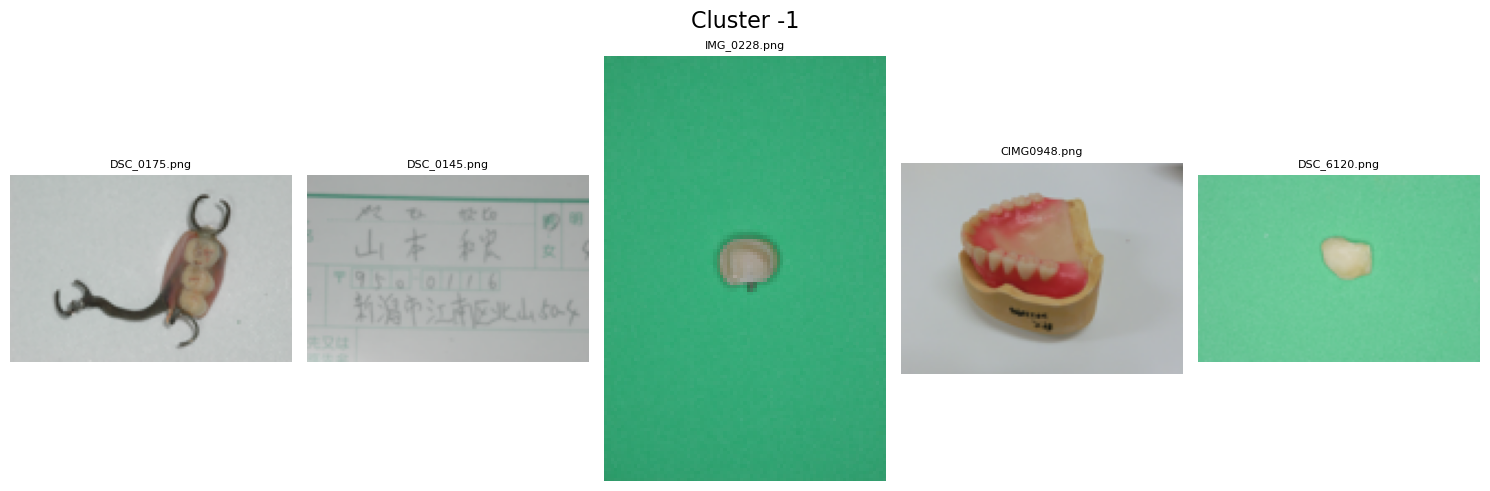

Cluster 0: 14715 images


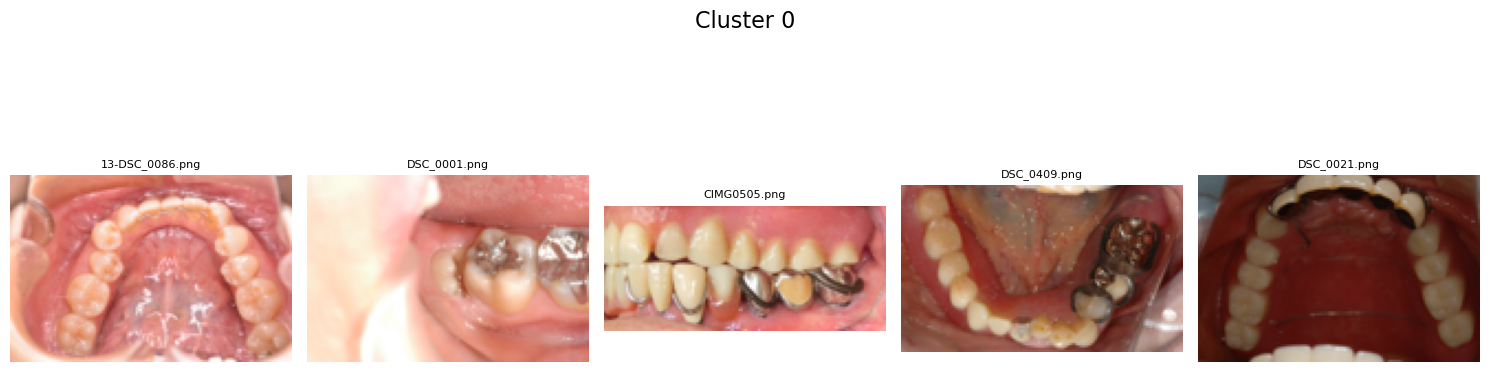

Cluster 1: 5 images


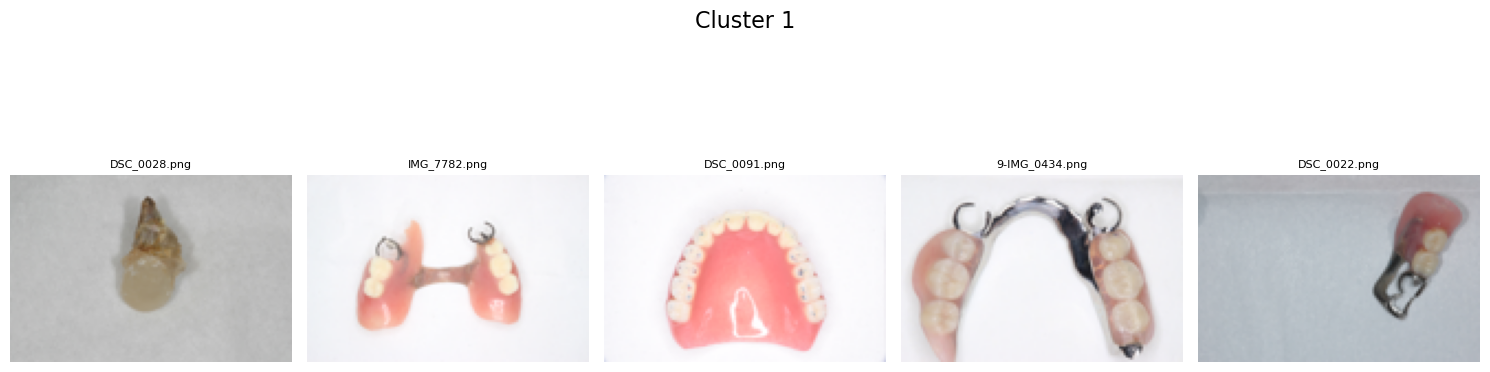

Cluster 2: 8 images


/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans

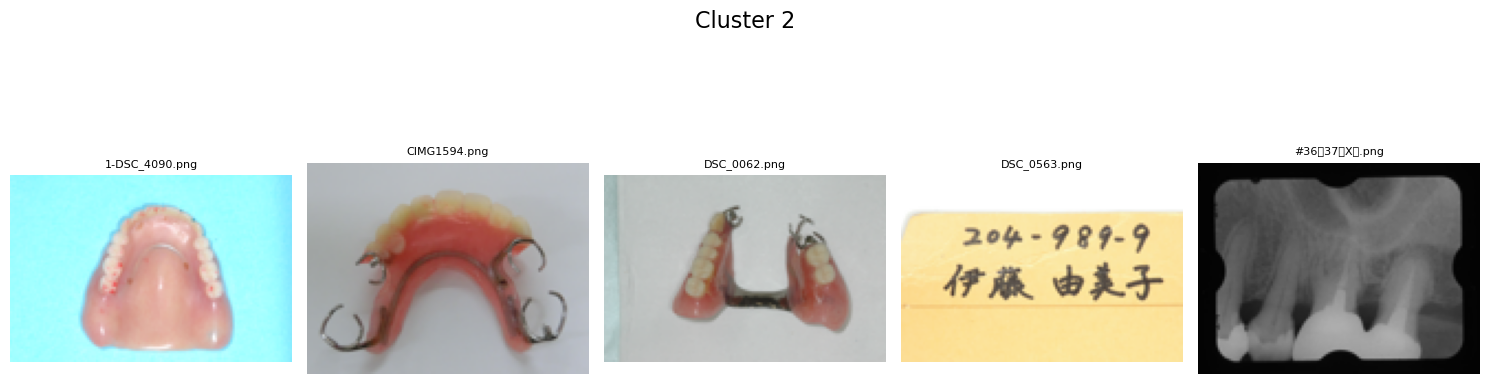

Cluster 3: 10 images


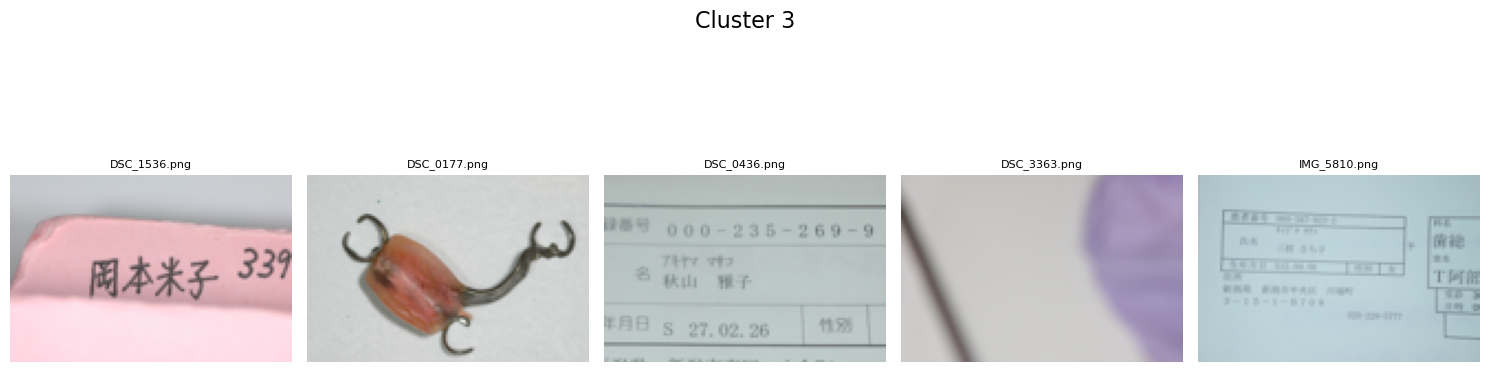

Cluster 4: 19 images


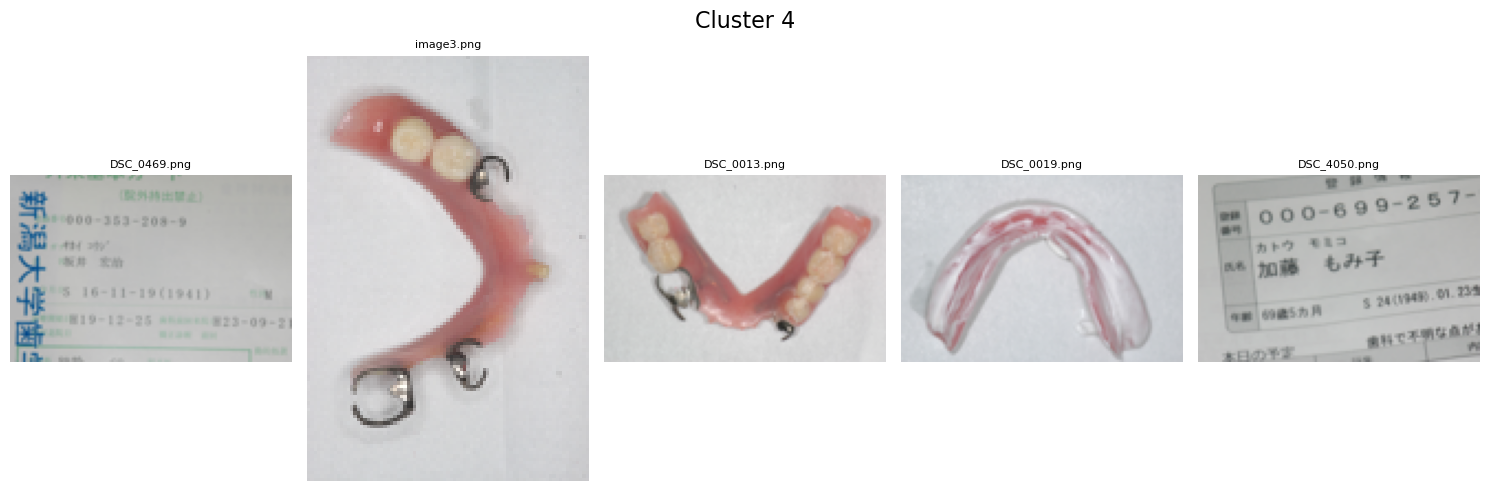

Cluster 5: 5 images


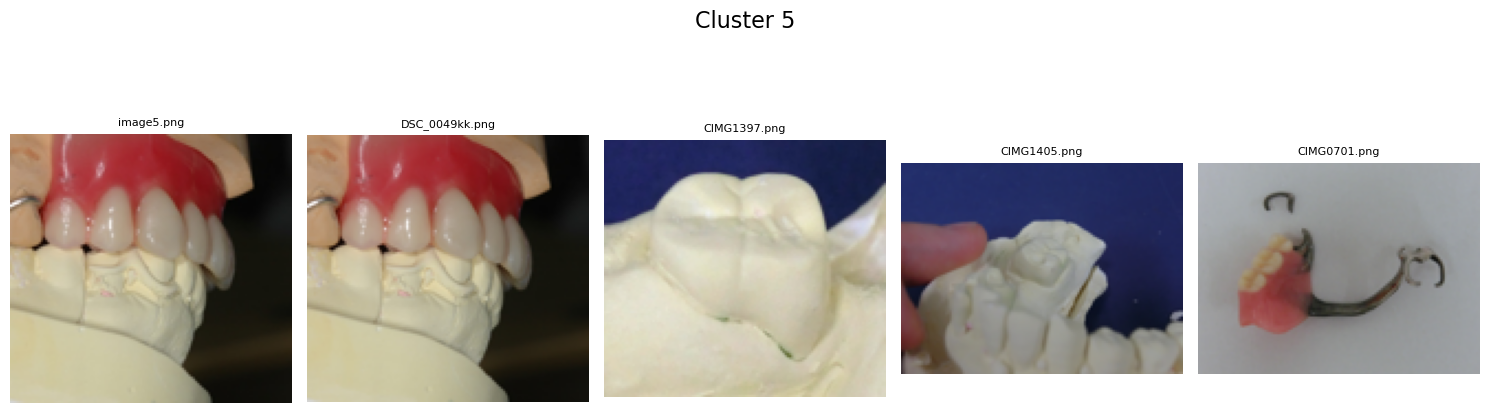

Cluster 6: 3 images


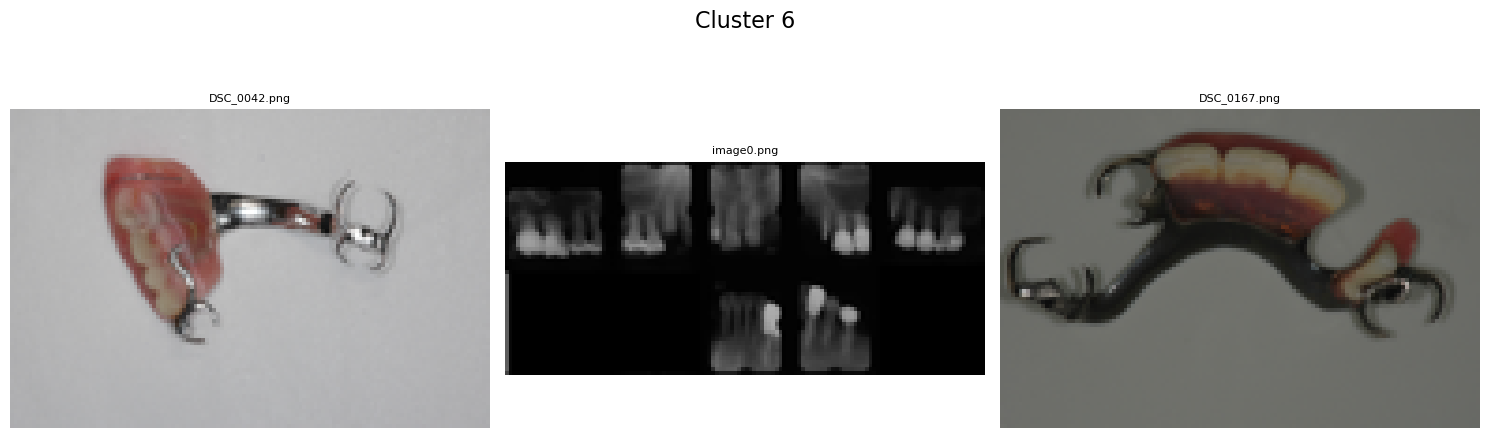

Cluster 7: 5 images


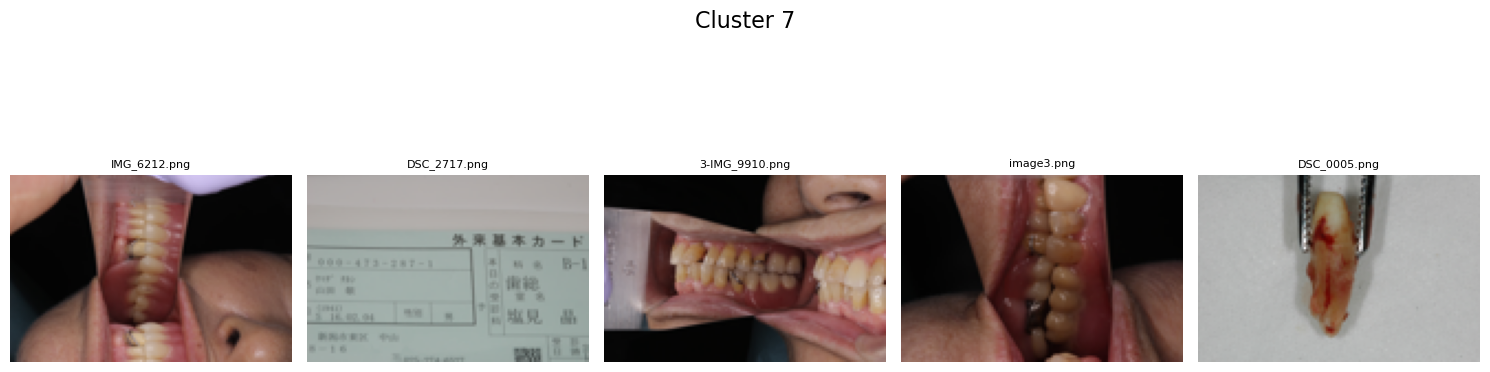


==== Displaying samples for color_histogram_std_UMAP_DBSCAN_cluster ====

Cluster 0: 13384 images


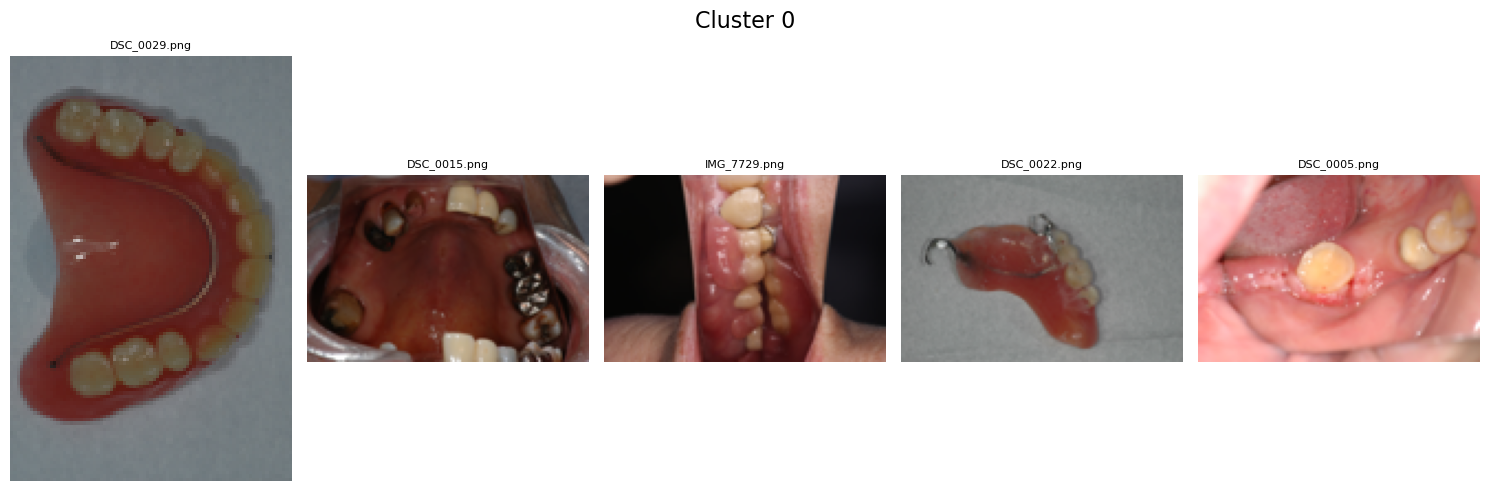

Cluster 1: 163 images


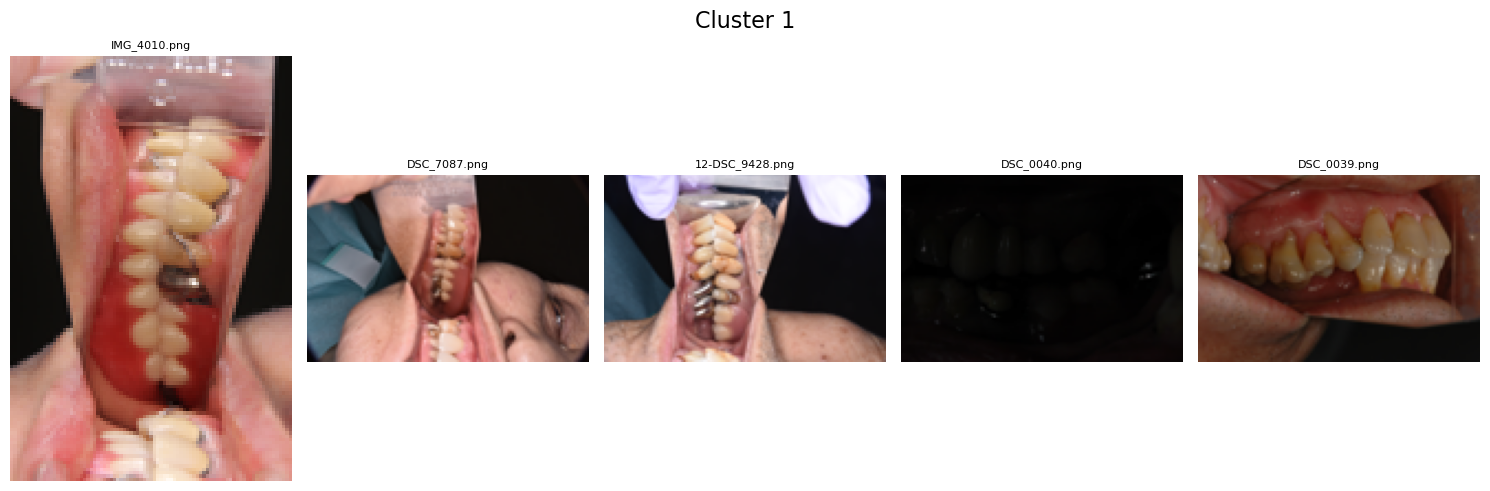

Cluster 2: 847 images


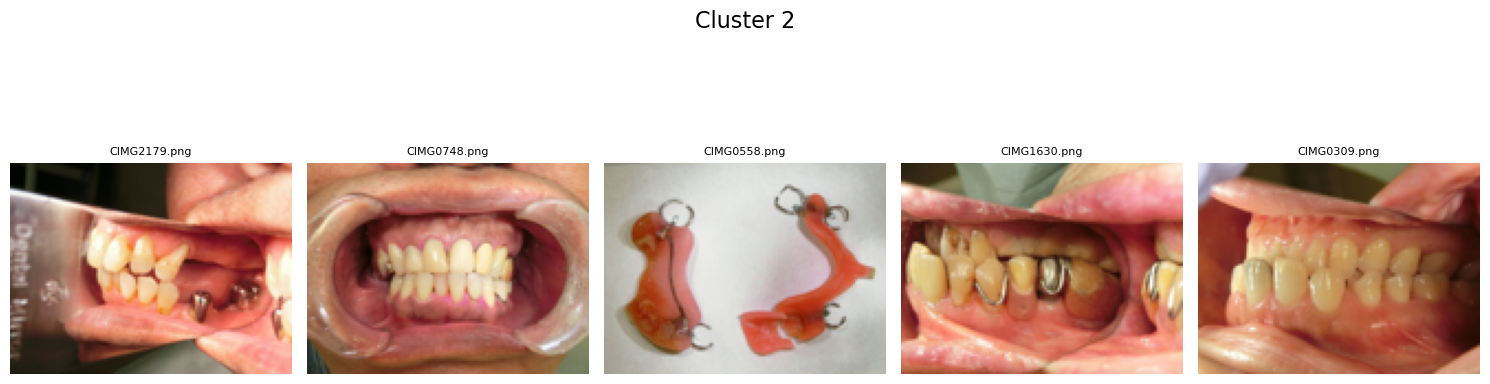

Cluster 3: 496 images


/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 65332 (\N{FULLWIDTH LATIN CAPITAL LETTER T}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 65317 (\N{FULLWIDTH LATIN CAPITAL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 65323 (\N{FULLWIDTH LATIN CAPITAL LETTER K}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 33292 (\N{CJK UNIFIED IDEOGRAPH-820C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 20596 (\N{CJK UNIFIED IDEOGRAPH-5074}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/v

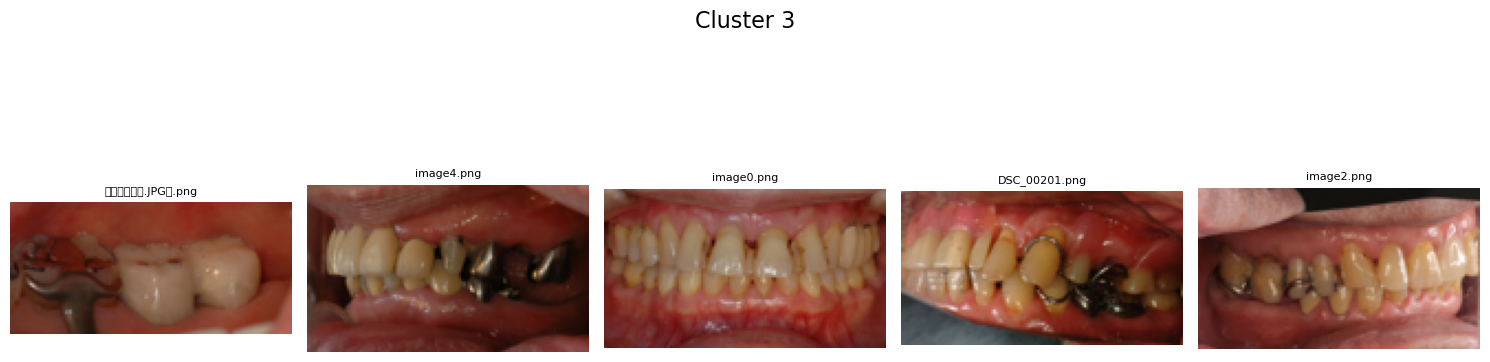


==== Displaying samples for glcm_features_std_PCA_GMM_cluster ====

Cluster 0: 3534 images


/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 33073 (\N{CJK UNIFIED IDEOGRAPH-8131}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33073 (\N{CJK UNIFIED IDEOGRAPH-8131}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


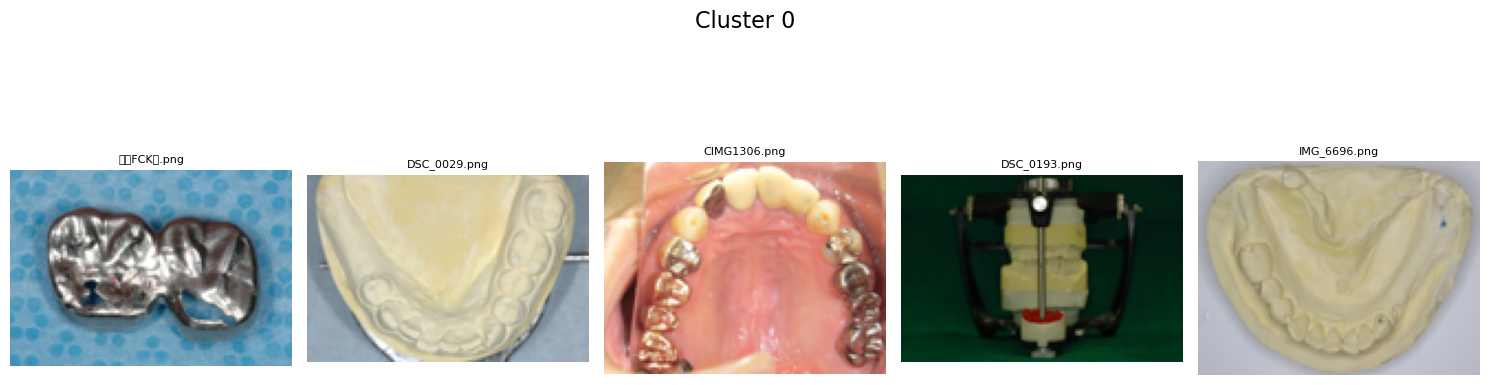

Cluster 1: 787 images


/var/folders/fn/kw77n3lx0y518806zc84d1m40000gn/T/ipykernel_99682/2367071205.py:39: UserWarning: Glyph 65343 (\N{FULLWIDTH LOW LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/ml_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65343 (\N{FULLWIDTH LOW LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


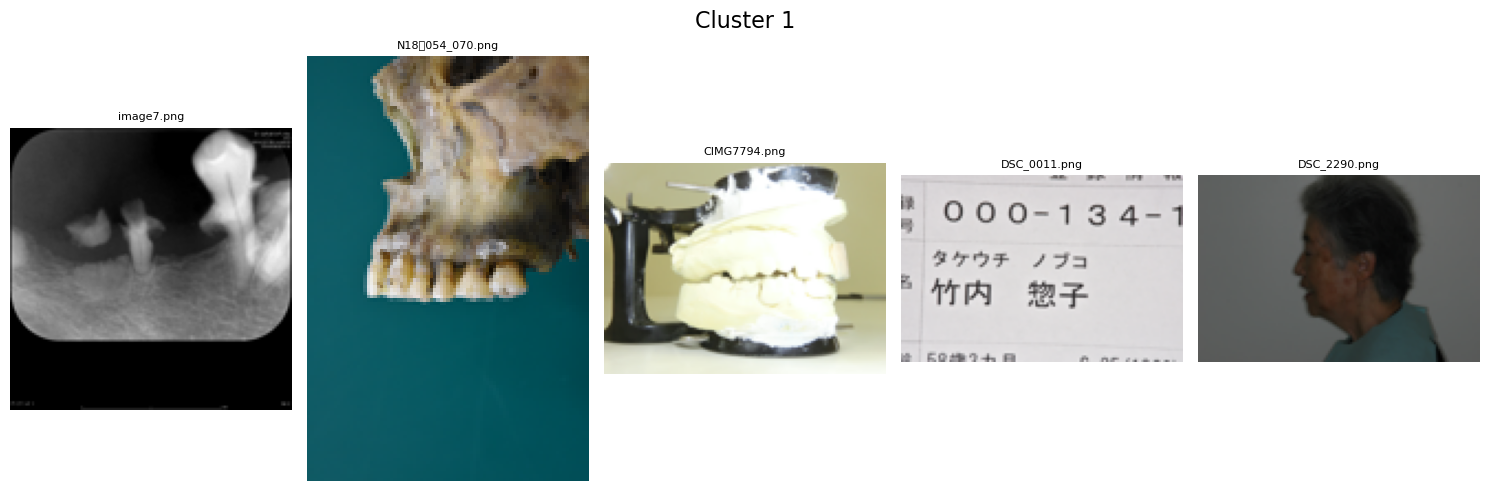

Cluster 2: 10569 images


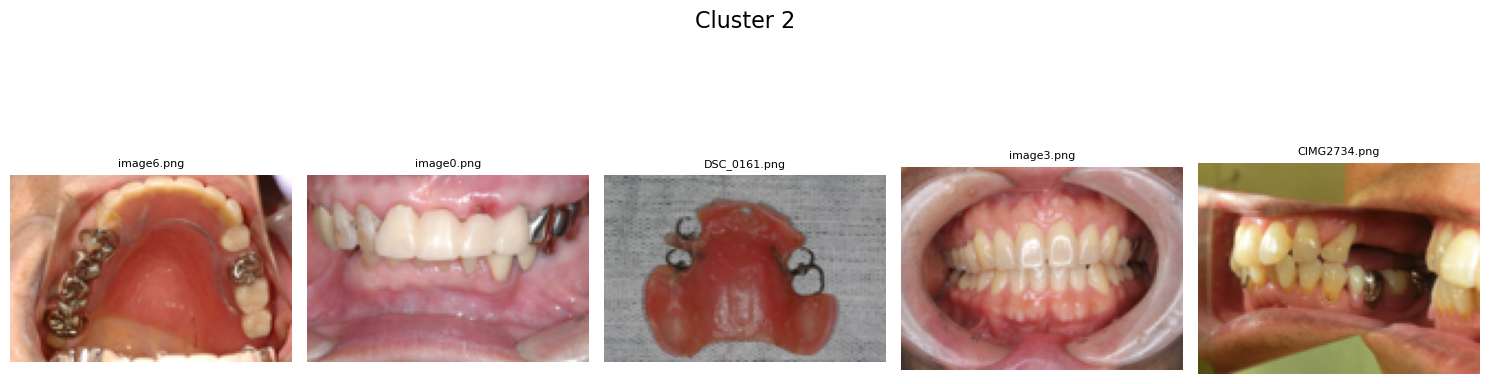


==== Displaying samples for hog_features_umap_std_UMAP_GMM_cluster ====

Cluster 0: 6104 images


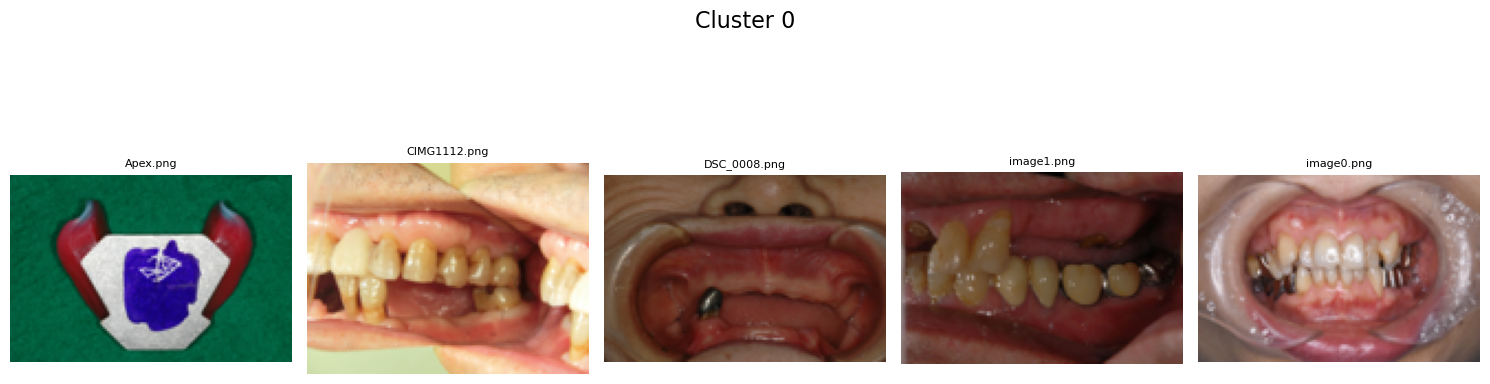

Cluster 1: 5417 images


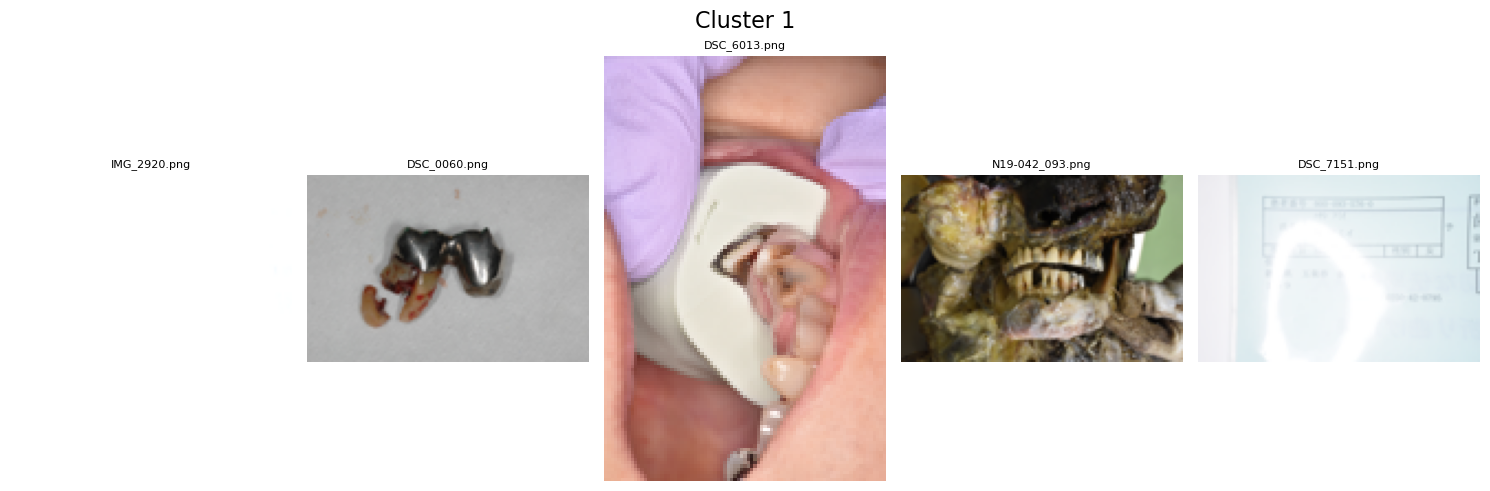

Cluster 2: 3369 images


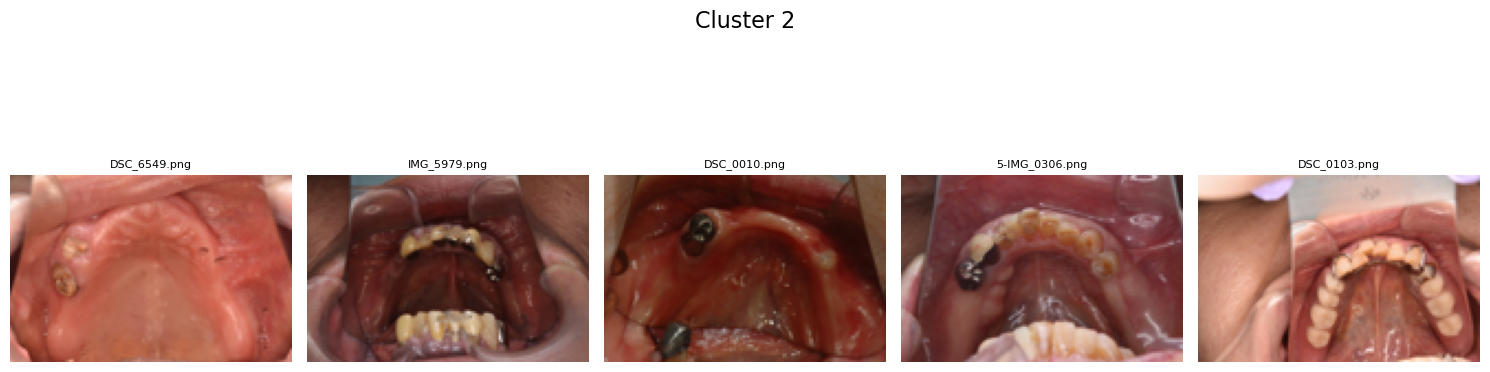

In [8]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_images_by_cluster(df, cluster_column, image_path_column='path', num_images=5):
    """
    各クラスターからランダムに指定した枚数の画像を表示する関数

    Args:
        df (DataFrame): クラスタリング結果を含むデータフレーム
        cluster_column (str): クラスタラベルが格納された列名
        image_path_column (str): 画像のパスが格納された列名
        num_images (int): 各クラスターから表示する画像の枚数
    """
    # クラスタごとにグループ化
    clusters = df.groupby(cluster_column)[image_path_column].apply(list).to_dict()
    
    for cluster_id, image_paths in clusters.items():
        print(f"Cluster {cluster_id}: {len(image_paths)} images")

        # クラスタ内からランダムに画像を選択
        sampled_images = random.sample(image_paths, min(len(image_paths), num_images))

        # サムネイル表示
        fig, axes = plt.subplots(1, len(sampled_images), figsize=(15, 5))
        fig.suptitle(f"Cluster {cluster_id}", fontsize=16)

        for ax, img_path in zip(axes, sampled_images):
            try:
                img = Image.open(img_path)
                img.thumbnail((128, 128))  # サムネイルサイズ
                ax.imshow(img)
                ax.axis("off")
                ax.set_title(img_path.split("/")[-1], fontsize=8)
            except Exception as e:
                ax.axis("off")
                ax.set_title("Error", fontsize=8)

        plt.tight_layout()
        plt.show()

# 表示したい列ごとにサンプル画像を表示
cluster_columns = [
    "color_histogram_std_PCA_DBSCAN_cluster",
    "color_histogram_std_UMAP_DBSCAN_cluster",
    "glcm_features_std_PCA_GMM_cluster",
    "hog_features_umap_std_UMAP_GMM_cluster"
]

for cluster_col in cluster_columns:
    print(f"\n==== Displaying samples for {cluster_col} ====\n")
    display_images_by_cluster(df_cluster, cluster_column=cluster_col)
